# Unitary cost function gradient descent

Created 03/10/2024

Objectives:
* For a given MPS, apply symmetry action and optimise for full unitary (i.e. not an MPO) at the boundary of the symmetry action. Then extract phase.
* When optimizing for the unitary and overlap costs, it's possible the optimal solution will not be unitary! How to resolve? Unitarity takes priority. But having a large unitarity step size can lead to divergences!
    * Could address this by performing unitarity gradient descent multiple times without overlap gradient descent when near optimum. Has effect of enhancing unitarity cost.

# Package imports

In [1]:
import sys
sys.path.append('../../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [34]:
import re

# Load data

In [9]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [10]:
f_name = DATA_DIR + r"/0_50.h5"

In [11]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_50.h5'

In [12]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitions

In [13]:
NUM_SITES = 6

In [17]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [18]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [19]:
symmetry_actions = [
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [20]:
cases = [
    SymmetryActionWithBoundaryUnitaries(test_psi, a*50)
    for a in symmetry_actions
]

In [21]:
for c in cases:
    c.compute_svd_symmetry_action()

## Functions

In [35]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [36]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [37]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [38]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [39]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [40]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [41]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [42]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [43]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [ ]:
def initialise_unitary(num_sites):
    

# Initial code

To-do:
* Initialize unitary
* Extract reduced density matrix
* Write functions to compute gradients
* Test

## Extract reduced density matrix

In [22]:
test_case = cases[1]

In [23]:
left_environment = test_case.right_projected_symmetry_state

In [24]:
left_environment

<npc.Array shape=(8, 8) labels=['vR', 'vR*']>

In [26]:
list(enumerate(range(10, 20)))

[(0, 10),
 (1, 11),
 (2, 12),
 (3, 13),
 (4, 14),
 (5, 15),
 (6, 16),
 (7, 17),
 (8, 18),
 (9, 19)]

In [27]:
bs = [
    test_case.psi.get_B(i)
    for i in range(
        test_case.right_symmetry_index + 1,
        test_case.right_symmetry_index + 1 + NUM_SITES
    )
]

In [28]:
len(bs)

6

In [31]:
t = left_environment

for i, b in enumerate(bs):
    b_current = b.replace_label('p', f'p{i}')

    t = npc.tensordot(t, b_current, [['vR'], ['vL']])
    t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])

t = npc.trace(t, 'vR', 'vR*')

In [32]:
t

<npc.Array shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2) labels=['p0', 'p0*', 'p1', 'p1*', 'p2', 'p2*', 'p3', 'p3*', 'p4', 'p4*', 'p5', 'p5*']>

In [46]:
leg_labels = [f'p{i}' for i in range(len(bs))]
leg_conj_labels = [f'p{i}*' for i in range(len(bs))]

In [47]:
grouped_t = t.combine_legs([leg_labels, leg_conj_labels])

In [48]:
grouped_t

<npc.Array shape=(64, 64) labels=['(p0.p1.p2.p3.p4.p5)', '(p0*.p1*.p2*.p3*.p4*.p5*)']>

In [68]:
matrix = get_identity_operator(grouped_t)

In [52]:
matrix

<npc.Array shape=(64, 64) labels=['(p0.p1.p2.p3.p4.p5)', '(p0*.p1*.p2*.p3*.p4*.p5*)']>

In [53]:
grouped_physical_leg_label = '(p0.p1.p2.p3.p4.p5)'
grouped_physical_leg_conj_label = '(p0*.p1*.p2*.p3*.p4*.p5*)'

In [350]:
def unitarity_gradient(matrix, grouped_physical_leg_label,
                      grouped_physical_leg_conj_label):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())
    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    return (t - matrix, score_2, score_4)

In [300]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (2*overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [414]:
def update(matrix, reduced_density_matrix, unitarity_scores, overlap_scores,
           target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, target=1):

    u_grad, u_score_2, u_score_4 = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    u_score = u_score_4 - 2*u_score_2 + matrix_dim
    unitarity_scores.append(u_score.real)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(np.abs(overlap))

    target_score = (
        overlap_lr*(target - np.abs(overlap))**2 +
        (unitarity_lr/4.0)*u_score.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    matrix -= gradient

## Testing

In [145]:
unitarity_scores = list()
overlap_scores = list()
matrix_dim = 2**6

In [146]:
reduced_density_matrix = grouped_t
matrix = get_identity_operator(grouped_t)

In [147]:
update(
    matrix,
    reduced_density_matrix,
    unitarity_scores,
    overlap_scores,
    grouped_physical_leg_label,
    grouped_physical_leg_conj_label,
    matrix_dim,
    unitarity_lr=0.1,
    overlap_lr=1
)

In [148]:
unitarity_scores

[0.0]

In [149]:
overlap_scores

[4.068655487521333e-08]

In [150]:
for _ in range(100):
    update(
        matrix,
        reduced_density_matrix,
        unitarity_scores,
        overlap_scores,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        matrix_dim,
        unitarity_lr=0.001,
        overlap_lr=0.001
    )

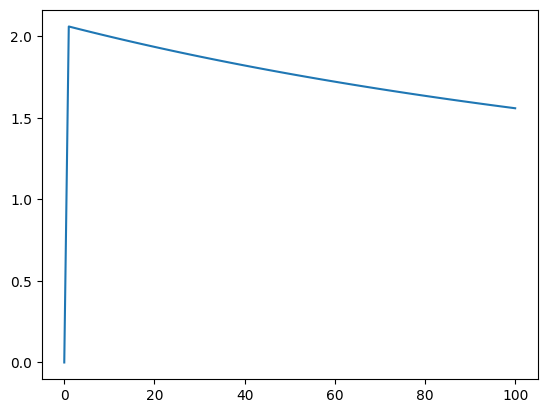

In [151]:
plt.plot(unitarity_scores)

In [152]:
unitarity_scores[-1]

1.5587969501706738

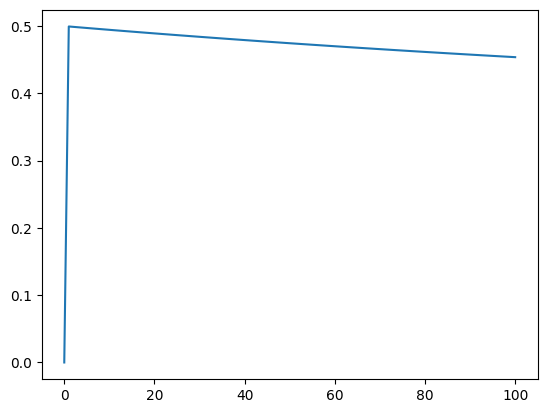

In [153]:
plt.plot(overlap_scores)

In [154]:
overlap_scores[-1]

0.453744894374123

## Test on scalars

In [415]:
scalar = 2*1j

In [416]:
scalar_rdm = npc.Array.from_ndarray_trivial(np.array([[scalar]]), labels=['p', 'p*'])

In [417]:
scalar_rdm

<npc.Array shape=(1, 1) labels=['p', 'p*']>

In [418]:
scalar_matrix = npc.Array.from_ndarray_trivial(np.array([[1]]), labels=['p', 'p*'])

In [419]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
target = np.abs(scalar)
matrix_dim = 1
scalar_matrix_values = [scalar_matrix[0,0],]

In [420]:
unitarity_lr = 0.01
overlap_lr = 0.01

In [421]:
update(
    scalar_matrix,
    scalar_rdm,
    unitarity_scores,
    overlap_scores,
    target_scores,
    'p',
    'p*',
    matrix_dim,
    unitarity_lr=unitarity_lr,
    overlap_lr=overlap_lr,
    target=target
)

scalar_matrix_values.append(np.abs(scalar_matrix[0,0]))

In [422]:
unitarity_scores

[0]

In [423]:
overlap_scores

[2.0]

In [424]:
for _ in range(100):
    update(
        scalar_matrix,
        scalar_rdm,
        unitarity_scores,
        overlap_scores,
        target_scores,
        'p',
        'p*',
        matrix_dim,
        unitarity_lr=unitarity_lr,
        overlap_lr=overlap_lr,
        target=target
    )

    scalar_matrix_values.append(np.abs(scalar_matrix[0,0]))

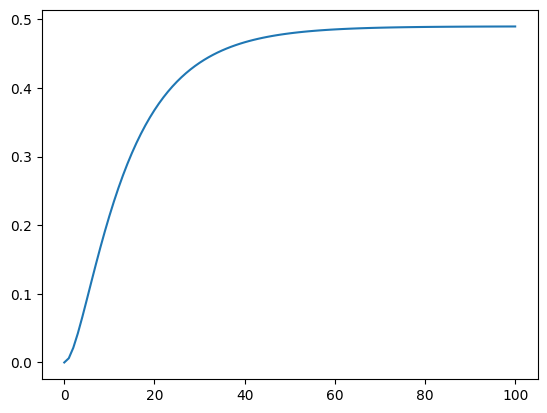

In [425]:
plt.plot(unitarity_scores)

In [426]:
unitarity_scores[-1]

0.4895190440719632

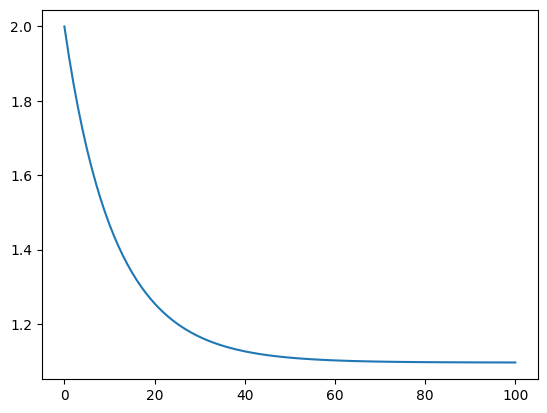

In [427]:
plt.plot(overlap_scores)

In [428]:
overlap_scores[-1]

1.0960723047131118

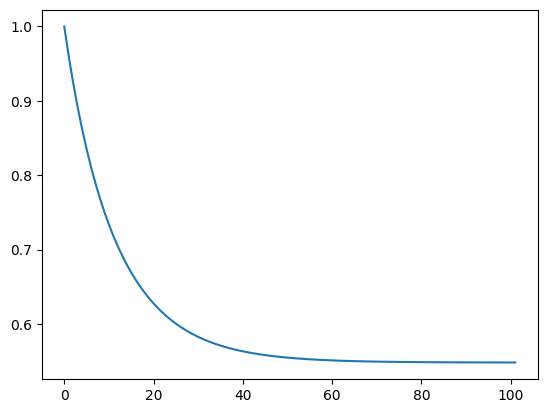

In [429]:
plt.plot(scalar_matrix_values)

In [430]:
scalar_matrix.to_ndarray()

array([[0.54802763+0.j]])

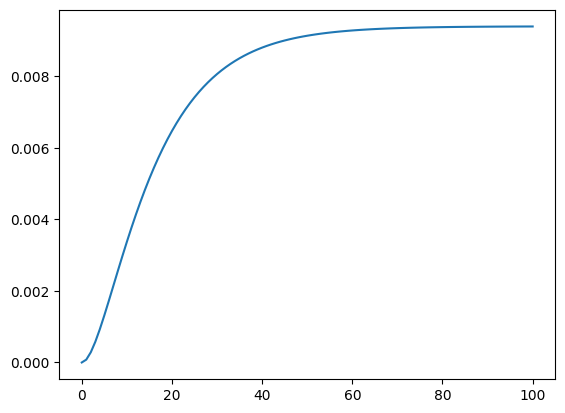

In [431]:
plt.plot(target_scores)

Debug this tomorrow!